# Memory Based Collaborative Filtering

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [2]:
USERS: int = 10
ITEMS: int = 15

MIN_RATING: int = 0
MAX_RATING: int = 5
    
MIN_SHARED_RATINGS: int = 3

In [3]:
ratings: np.array = MAX_RATING * np.random.randn(USERS, ITEMS)
ratings[ratings < MIN_RATING] = np.nan
ratings[ratings > MAX_RATING] = MAX_RATING
ratings = np.floor(ratings)
print(ratings)

[[nan  0. nan nan  5. nan  1.  2. nan  2. nan  0. nan  5.  5.]
 [ 4. nan nan  5.  3. nan nan nan  2.  0.  5.  1.  3.  3.  4.]
 [ 3.  0. nan  1. nan  0. nan nan  4. nan  5. nan  5.  4. nan]
 [nan nan nan nan nan nan nan  1.  5.  5.  0. nan nan nan  3.]
 [ 3.  1.  0.  1. nan  5.  5.  1. nan  1. nan nan nan nan nan]
 [nan  1. nan  5. nan  3.  5.  5. nan  2.  1.  4.  5.  5.  1.]
 [ 5. nan  5. nan nan  5.  3. nan nan nan nan  4.  2. nan nan]
 [ 5.  5.  5.  0. nan nan  1. nan  4.  5. nan  0. nan nan nan]
 [nan  2. nan nan  3.  3.  1. nan nan nan  0. nan nan nan nan]
 [ 3. nan  0. nan nan nan nan  1. nan nan  3. nan  5.  1.  0.]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [4]:
def get_normalized_matrix(matrix: np.array) -> tuple:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    mean: np.array = np.nansum(matrix, axis=1) / sample_size
    mean = mean.reshape(mean.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - mean, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    variation: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - variation) / variation
    return mean, variation, normalized

ORIGINAL [[-0.37341985  0.53709025  3.3252004   2.33483917  3.79859824  5.7956564
   7.24311885  9.42478936  8.71480907 10.63627607]
 [20.10353651 26.32697886 32.04976426 39.64818044 46.69843111 54.39478915
  59.51595133 66.74614796 72.69768483 81.20996277]]
NORMALIZED [[-1.10327177 -0.85146408 -0.08039347 -0.35428453  0.05052788  0.60282774
   1.00313321  1.60648886  1.41013903  1.94153365]
 [ 0.03483699  0.35519099  0.64977349  1.04090477  1.40381904  1.79999192
   2.06360564  2.43578269  2.74214025  3.18031291]]


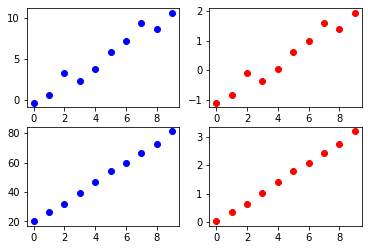

In [5]:
x: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
mean, variation, y = get_normalized_matrix(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Entropy

- https://en.wikipedia.org/wiki/Entropy_(information_theory)

In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

$$ H(x) = - \sum\limits^{^n}_{i=1} P(x_i) \cdot log P(x_i) $$

In [6]:
def get_entropy_array(matrix: np.array) -> np.array:
    """
    Entropy Matrix.
    """
    P: np.matrix = np.count_nonzero(~np.isnan(matrix.T), axis=1) / matrix.shape[0]
    P[P == 0] = 1
    return np.abs(np.log(P))

In [7]:
X: np.array = np.array([
    [1, np.nan, 3, np.nan, np.nan],
    [4, 5, np.nan, np.nan, np.nan],
    [7, 8, 9, 5, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [1, 2, 2, np.nan, np.nan]
])
E: np.array = get_entropy_array(X)
print(X)
print(E)

[[ 1. nan  3. nan nan]
 [ 4.  5. nan nan nan]
 [ 7.  8.  9.  5. nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 1.  2.  2. nan nan]]
[0.         0.13353139 0.13353139 2.07944154 0.        ]


## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [8]:
def get_cosine(X: np.array, Y: np.array) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(MIN_SHARED_RATINGS, np.count_nonzero(union)) / MIN_SHARED_RATINGS
    return discount * np.sum(X[union] * Y[union]) / \
        (max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         max(0.0000001, np.sqrt(np.sum(np.power(Y[union], 2)))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


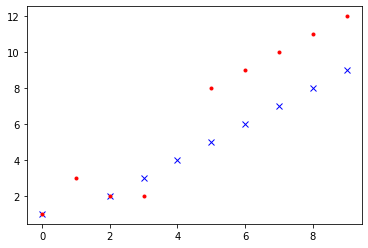

In [9]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


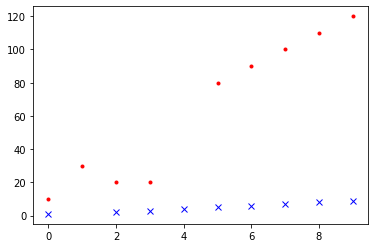

In [10]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


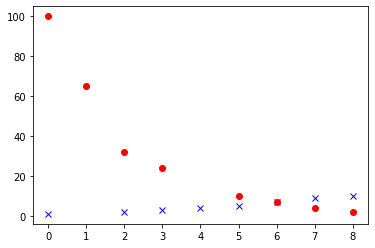

In [11]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [12]:
def get_similarity_matrix(matrix: np.array) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    correlations: np.array = np.stack([
        [
            0 if i >= j else get_cosine(x, y)
            for j, y in enumerate(matrix)
        ]
        for i, x in enumerate(matrix)
    ])
    return correlations + correlations.T

In [13]:
X: np.array = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
S: np.array = get_similarity_matrix(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.95941195]
 [0.97463185 0.         0.99819089]
 [0.95941195 0.99819089 0.        ]]


## Top K-Similar Rows

- https://en.wikipedia.org/wiki/Adjacency_matrix
- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In [14]:
def get_adjacency_matrix(similar: np.array, k: int = 5) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - k:]

In [15]:
X: np.array = np.array([ [0, 2, 3, 1], [8, 0, 6, 1], [7, 6, 0, 2], [2, 3, 1, 0] ])
S: np.array = get_adjacency_matrix(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


### Collaborative Filtering

In [20]:
def get_collaborative_filtering(ratings: np.array, mean: np.array, variance: np.array, entropy: np.array, adjacent: np.array) -> np.matrix:
    """
    Collaborative Filtering function.
    """
    print(1, ratings)
    print(2, mean)
    print(3, variance)
    print(4, entropy)
    print(5, adjacent)
    for i in range(ratings.shape[0]):
        print(1, ratings[i])
        

    
X: np.array = np.array([
    [1, np.nan, 3, 5, 0],
    [1, 8, 3, 7, np.nan],
    [np.nan, np.nan, 3, np.nan, 0],
    [1, np.nan, np.nan, 5, 9],
])
mean, variance, normalized = get_normalized_matrix(X)
entropy = get_entropy_array(X.T)
similarity = get_similarity_matrix(normalized)
adjacent = get_adjacency_matrix(similarity)
F: np.matrix = get_collaborative_filtering(ratings=normalized, mean=mean, variance=variance, entropy=entropy, adjacent=adjacent)
print(X)
print(F)

1 [[-0.47924436         nan  0.56226693  1.60377822 -1.        ]
 [-0.65051838  1.79585298  0.04844487  1.44637136         nan]
 [        nan         nan  1.                 nan -1.        ]
 [-0.69381378         nan         nan  0.53093109  1.75567596]]
2 [[2.25]
 [4.75]
 [1.5 ]
 [5.  ]]
3 [[1.92028644]
 [2.86138079]
 [1.5       ]
 [3.26598632]]
4 [0.22314355 0.22314355 0.91629073 0.51082562]
5 [[1]
 [0]
 [0]
 [1]]
1 [-0.47924436         nan  0.56226693  1.60377822 -1.        ]
1 [-0.65051838  1.79585298  0.04844487  1.44637136         nan]
1 [nan nan  1. nan -1.]
1 [-0.69381378         nan         nan  0.53093109  1.75567596]
[[ 1. nan  3.  5.  0.]
 [ 1.  8.  3.  7. nan]
 [nan nan  3. nan  0.]
 [ 1. nan nan  5.  9.]]
None


## User-Based Collaborative Filtering

#### User-User Matrix

In [ ]:
print(ratings.shape)
print(ratings)

#### User-User Normalized Matrix

In [ ]:
mean, variation, normalized = get_normalized_matrix(ratings)
print(normalized.shape)
print(normalized)

#### User-User Similarity Matrix

In [ ]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

#### User-User Adjacency Matrix

In [ ]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

#### Items Entropy Matrix

In [ ]:
entropy: np.array = get_entropy_array(ratings)
print(entropy.shape)
print(entropy)

## Memory-Based Collaborative Filtering

#### Item-Item Matrix

In [ ]:
print(ratings.T.shape)
print(ratings.T)

#### Item-Item Normalized Matrix

In [ ]:
mean, variation, normalized = get_normalized_matrix(ratings.T)
print(normalized.shape)
print(normalized)

#### Item-Item Similarity Matrix

In [ ]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

#### Item-Item Adjacency Matrix

In [ ]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

#### Users Entropy Matrix

In [ ]:
entropy: np.array = get_entropy_array(ratings.T)
print(entropy.shape)
print(entropy)